# Model the Data Using Different Models

## Import Libraries

In [1]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

## Read the Data

In [2]:
# Read the CSV file
final_df = pd.read_csv('averaged_final_2.csv')

## Clean the Data

In [3]:
# Convert the 'change' column to string
final_df['change']=final_df['change'].astype(str)

In [4]:
# Drop the 'Unnamed: 0' column
final_df = final_df.drop(columns=['Unnamed: 0'])

In [5]:
# Convert the 'change' column to boolean
final_df['change'] = final_df['change'].apply(lambda x: 1 if x == "True" else 0)

## Logistic Regression Model

In [7]:
# Define the function
def log_regression(x, y, plot=False):
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Encode labels (for categorical y)
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Train Logistic Regression model
    model = LogisticRegression(max_iter=500)
    model.fit(X_train_scaled, y_train_encoded)

    # Model accuracy
    accuracy = model.score(X_test_scaled, y_test_encoded)

    # Permutation importance
    perm_imp = permutation_importance(model, X_test_scaled, y_test_encoded, scoring='accuracy', n_repeats=10, random_state=42)

    # Fix sorting issue
    feature_importance = np.abs(perm_imp.importances_mean)  # Take absolute values
    feature_names = np.array(x.columns)  # Ensure it's an array
    sorted_idx = np.argsort(-feature_importance)  # Sort in descending order

    # Create DataFrame for readability
    perm_df = pd.DataFrame({'feature': feature_names[sorted_idx], 'importance': feature_importance[sorted_idx]})

    # Plot Feature Importance
    if plot:
        plt.figure(figsize=(10, 5))
        plt.bar(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
        plt.xticks(range(len(sorted_idx)), feature_names[sorted_idx], rotation=90)
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.title('Feature Importance for Logistic Regression')
        plt.show()

    important_features = feature_names[sorted_idx].tolist()

    
    return model, accuracy, important_features

## Random Forest Model

In [8]:
# Define the function
def rfc(x, y, plot):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    best_accuracy = 0
    best_model = None
    for _ in range(100):
        model = RandomForestClassifier()
        model.fit(X_train, y_train_encoded)
        acc = model.score(X_test, y_test_encoded)
        if acc > best_accuracy:
            best_accuracy = acc
            best_model = model
    model_RFC = best_model
    accuracy_RFC = best_accuracy

    feature_importance = np.abs(model_RFC.feature_importances_)
    sorted_idx = np.argsort(feature_importance)[::-1]

    # Retrieve column names before scaling
    feature_names = x.columns
    

    if plot==True:

        plt.figure(figsize=(10, 5))
        plt.bar(range(len(feature_importance)), feature_importance[sorted_idx])
        plt.xticks(range(len(feature_importance)), feature_names[sorted_idx], rotation=90)
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.title('Feature Importance for RFC')
        plt.show()
    important_features = feature_names[sorted_idx].tolist()
    return model_RFC, accuracy_RFC, important_features

In [9]:
# Define the function
def choose_lowest_error_features(x, y, model_to_fit):
    # Model selection
    if model_to_fit == 'rfc':
        func = rfc
        name = "Random Forest Classifier"
    elif model_to_fit == 'log':
        func = log_regression
        name = "Logistic Regression"
    else:
        print("Invalid model name. Please choose 'rfc' or 'log'.")
        return

    # Initial full model to get feature ranking
    _, _, important_features = func(x, y, False)

    # Cap max features to avoid excessive iteration
    max_features = min(len(important_features), 12)
    accuracy_list = {}

    for i in range(1, max_features + 1):
        subset = important_features[:i]
        _, acc, _ = func(x[subset], y, False)
        accuracy_list[i] = acc

    # Determine best subset
    max_accuracy = max(accuracy_list.values())
    best_feature_counts = [k for k, v in accuracy_list.items() if v == max_accuracy]
    best_num_features = max(best_feature_counts)
    best_features = important_features[:best_num_features]

    print(f"Using the model: {name}")
    print(f"Maximum accuracy: {max_accuracy:.4f} with the features: {best_features}")
    print(f"Choosing the first {best_num_features} features")

    return best_features, max_accuracy

## XGBoost Model

In [10]:
# Define the function
def xgboost(x, y):
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

    # Train XGBoost model
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)

    # Model accuracy
    accuracy = model.score(X_test, y_test)

    print("Accuracy for XGBoost:", accuracy)

## Model Results

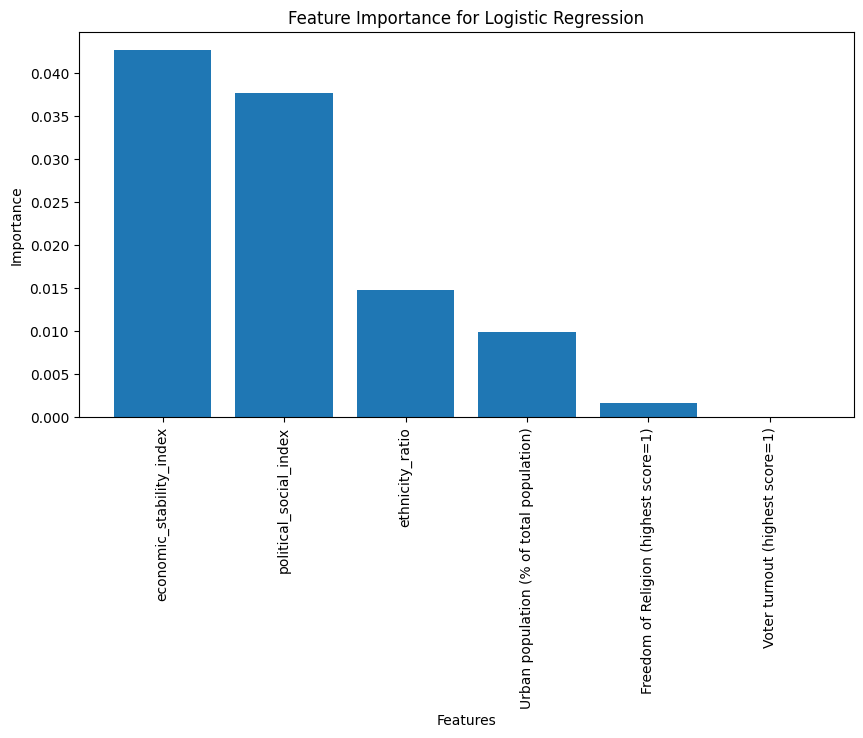

Accuracy for Logistic Regression: 0.5081967213114754


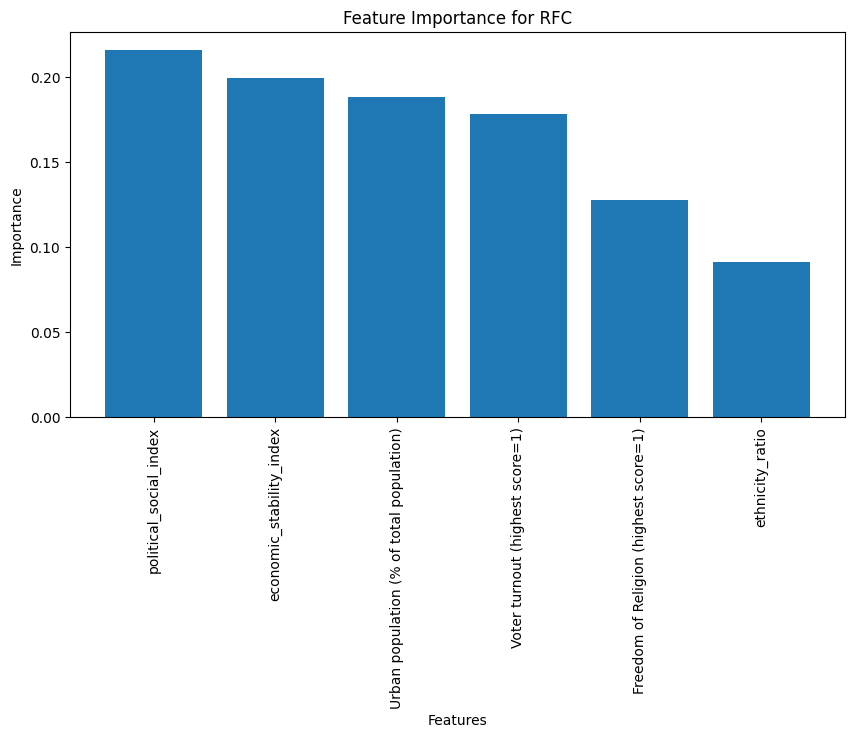

Accuracy for Random Forest Classifier: 0.639344262295082


In [11]:
model_final_df,result, feature_list=log_regression(final_df.drop(columns=['country', 'range', 'year', 'change']), final_df['change'], True)
print("Accuracy for Logistic Regression:", result)
rfc_final_df,result, feature_list=rfc(final_df.drop(columns=['country', 'range', 'year', 'change']), final_df['change'], True)
print("Accuracy for Random Forest Classifier:", result)

In [12]:
# Call the function
xgboost(final_df.drop(columns=['country', 'range', 'year', 'change']), final_df['change'])

Accuracy for XGBoost: 0.6086956521739131


In [13]:
# Call the function
choose_lowest_error_features(final_df.drop(columns=['country', 'range', 'year', 'change']), final_df['change'],'log')
choose_lowest_error_features(final_df.drop(columns=['country', 'range', 'year', 'change']), final_df['change'],'rfc')

Using the model: Logistic Regression
Maximum accuracy: 0.5246 with the features: ['economic_stability_index', 'political_social_index', 'ethnicity_ratio', 'Urban population (% of total population)']
Choosing the first 4 features
Using the model: Random Forest Classifier
Maximum accuracy: 0.6557 with the features: ['political_social_index', 'economic_stability_index', 'Urban population (% of total population)', 'Voter turnout (highest score=1)', 'Freedom of Religion (highest score=1)', 'ethnicity_ratio']
Choosing the first 6 features


(['political_social_index',
  'economic_stability_index',
  'Urban population (% of total population)',
  'Voter turnout (highest score=1)',
  'Freedom of Religion (highest score=1)',
  'ethnicity_ratio'],
 0.6557377049180327)